In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
import gym
from gym.envs.toy_text.frozen_lake import generate_random_map
from tqdm import tqdm
from bettermdptools.algorithms.planner import Planner
from bettermdptools.utils.plots import Plots
from bettermdptools.algorithms.rl import RL
from bettermdptools.utils.test_env import TestEnv
from bettermdptools.utils.grid_search import GridSearch
from bettermdptools.utils.blackjack_wrapper import BlackjackWrapper
import time
import csv
import pygame
import itertools
import gc
from scipy import stats

gc.collect();
#from A4_Utils import mode_policy_dict,visualize_policy

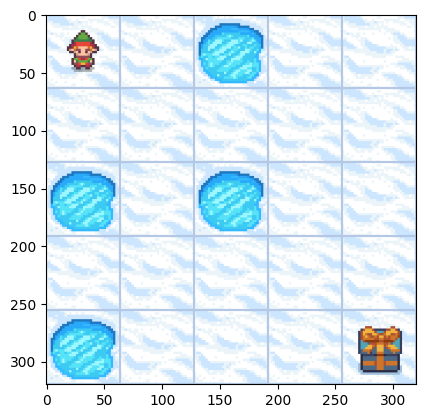

In [8]:
#Selecting a large frozen lake for an MDP
size_val=5
seed=42
frozen_lake = gym.make('FrozenLake-v1', desc=generate_random_map(size=size_val) ,is_slippery=True, render_mode="rgb_array", negative_reward_hole=True)
frozen_lake.reset(seed=seed);
plt.imshow(frozen_lake.render())

In [9]:
np.save('saved_data/frozenlake_5.npy',frozen_lake.desc)

### Helper Functions

In [10]:
def mode_policy_dict(policies,gammas):
    '''Function to compute optimal policy for each gamma value using mode'''
    mode_policies=np.zeros(shape=(gammas.shape[0],len(policies[list(policies.keys())[0]])))
    for i,g in enumerate(gammas):
        master_key='{:.2f}_'.format(g)
        big_array=None
        short_listed_keys=[]
        for k in policies.keys():
            if master_key in k:
                short_listed_keys.append(k)
            else:
                pass
        for ii,s_k in enumerate(short_listed_keys):
            if ii==0:
                big_array=np.array(list(policies[s_k].values()))
            else:
                big_array=np.c_[big_array,np.array(list(policies[s_k].values()))]
            
        #Getting Mode
        mode_policies[i]=stats.mode(big_array,axis=1)[0].ravel()
    return mode_policies


In [11]:
def visualize_policy(policies,env,gammas,title_header='None',row=3,cols=5, axes_in=None):
    #env=[v.decode('ascii') for v in env]
    env=env.ravel()
    arrow_colors = {
    0: 'blue',
    1: 'black',
    2: 'red',
    3: 'green'
    }

    grid_colors={
        b'H': 'red',
        b'G': 'green',
        b'F': 'grey',
        b'S': 'grey'
    }

    if axes_in is None:
        fig, axes = plt.subplots(row,cols)
        fig.set_size_inches(10*cols,5*row)
        plt.suptitle(f'{title_header} Policies Plotted',fontsize=18)
        for i,ax in enumerate(axes.flatten()):
            policy=policies[i]
            ax.set_title('Gamma: {:.2f}'.format(gammas[i]))
            ax.set_xticks(np.arange(policy.shape[0]**(0.5)))
            ax.set_yticks(-1*np.arange(policy.shape[0]**(0.5)))
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.grid(True)

            for ii in range(len(policy)):
                if policy[ii]==2:
                    arrow = '→'
                elif policy[ii]==0:
                    arrow = '←'
                elif policy[ii]==3:
                    arrow = '↑'
                elif policy[ii]==1:
                    arrow = '↓'
                else:
                    continue
                x=int(ii%policy.shape[0]**(0.5))
                y=-int(ii/policy.shape[0]**(0.5))
                rect = plt.Rectangle((x, y), 1, 1, color=grid_colors[env[ii]], alpha=0.1)
                ax.add_patch(rect)
                ax.text(x,y,arrow, ha='center', va='center', color=arrow_colors[policy[ii]])
        plt.tight_layout()
        plt.show()
    else:
        for i,ax in enumerate(axes_in.flatten()):
            policy=policies[i]
            ax.set_title('Policy Visualized')
            ax.set_xticks(np.arange(policy.shape[0]**(0.5)))
            ax.set_yticks(-1*np.arange(policy.shape[0]**(0.5)))
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.grid(True)

            for ii in range(len(policy)):
                if policy[ii]==2:
                    arrow = '→'
                elif policy[ii]==0:
                    arrow = '←'
                elif policy[ii]==3:
                    arrow = '↑'
                elif policy[ii]==1:
                    arrow = '↓'
                else:
                    continue
                x=int(ii%policy.shape[0]**(0.5))
                y=-int(ii/policy.shape[0]**(0.5))
                rect = plt.Rectangle((x, y), 1, 1, color=grid_colors[env[ii]], alpha=0.1)
                ax.add_patch(rect)
                ax.text(x,y,arrow, ha='center', va='center', color=arrow_colors[policy[ii]])

In [12]:
def visualize_heatmap_states(values,gammas,title_header='None',row=3,cols=5):
    #env=[v.decode('ascii') for v in env]
    fig, axes = plt.subplots(row,cols)
    fig.set_size_inches(10*cols,5*row)
    plt.suptitle(f'{title_header} Policies Plotted',fontsize=18)

    for i,ax in enumerate(axes.flatten()):
        value=values[i,:]
        ax.set_title('Gamma: {:.2f}'.format(gammas[i]))
        ax.set_xticks(np.arange(values.shape[0]**(0.5)))
        ax.set_yticks(-1*np.arange(values.shape[0]**(0.5)))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        heatmap=ax.imshow(value.reshape(int(len(value)**(0.5)),int(len(value)**(0.5))), cmap='jet', interpolation='lanczos')
        plt.colorbar(heatmap, ax=ax)
    plt.tight_layout()
    plt.show()

### Policy Iteration

In [13]:
#Initializing gamms
gammas=np.arange(0.57,1.0,0.03)

In [14]:
#Testing the effect of convergence rate for the same convergence value for frozen lakes
REPEATS=5
iters=5000
convergence_policy_iterations=np.zeros(shape=(gammas.shape[0],REPEATS))
times_policy_iterations=np.zeros(shape=(gammas.shape[0],REPEATS))
v_policy_iterations=np.zeros(shape=(len(gammas),REPEATS,size_val**2))
vi_policy_all_iterations=np.zeros(shape=(len(gammas),REPEATS,iters,size_val**2))
pi_policy_iteraetions={}

for big_i,gamma in tqdm(enumerate(gammas)):
    for i in range(REPEATS):
        frozen_lake.reset()
        
        #Solving
        start=time.time()
        V, V_track, pi, convergence_i = Planner(frozen_lake.P).policy_iteration(gamma=gamma,n_iters=iters)
        end=time.time()

        #Storing Time
        times_policy_iterations[big_i,i]=end-start

        #Getting iterations
        convergence_policy_iterations[big_i,i]=convergence_i

        #Storing policy
        pi_policy_iteraetions['{:.2f}_{}'.format(gamma,i)]=pi

        #Stroing ideal V
        v_policy_iterations[big_i,i]=V

        #Storing V historic
        V_track[np.argwhere(V_track.sum(axis=-1)==0)[1][0]:]=V_track[np.argwhere(V_track.sum(axis=-1)==0)[1][0]-1]
        vi_policy_all_iterations[big_i,i]=V_track

15it [00:00, 17.83it/s]


In [15]:
#Testing the effect of convergence rate for the same convergence value for frozen lakes
REPEATS=5
iters=5000
convergence_value_iterations=np.zeros(shape=(gammas.shape[0],REPEATS))
times_value_iterations=np.zeros(shape=(gammas.shape[0],REPEATS))
v_value_iterations=np.zeros(shape=(len(gammas),REPEATS,size_val**2))
vi_value_all_iterations=np.zeros(shape=(len(gammas),REPEATS,iters,size_val**2))
pi_value_iteraetions={}

for big_i,gamma in tqdm(enumerate(gammas)):
    for i in range(REPEATS):
        frozen_lake.reset()
        
        #Solving
        start=time.time()
        V, V_track, pi, convergence_i = Planner(frozen_lake.P).value_iteration(gamma=gamma,n_iters=iters)
        end=time.time()

        #Storing Time
        times_value_iterations[big_i,i]=end-start

        #Getting iterations
        convergence_value_iterations[big_i,i]=convergence_i

        #Storing policy
        pi_value_iteraetions['{:.2f}_{}'.format(gamma,i)]=pi

        #Stroing ideal V
        v_value_iterations[big_i,i]=V

        #Storing V historic
        V_track[np.argwhere(V_track.sum(axis=-1)==0)[1][0]:]=V_track[np.argwhere(V_track.sum(axis=-1)==0)[1][0]-1]
        vi_value_all_iterations[big_i,i]=V_track

15it [00:01, 13.72it/s]


Text(0, 0.5, 'Number of Iterations')

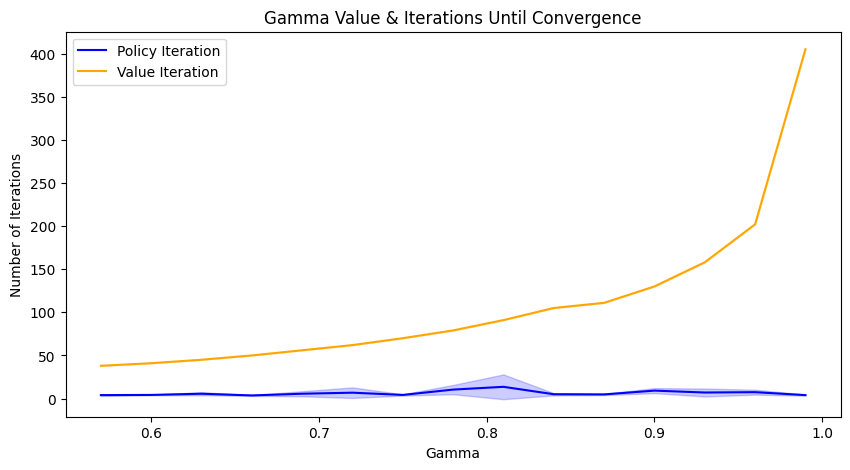

In [28]:
#Plot number of iterations for policy iteration
fig=plt.figure()
fig.set_size_inches(10,5)
plt.title('Gamma Value & Iterations Until Convergence')
#plt.scatter(gammas,convergence_policy_iterations.mean(axis=1),label='Policy Iteration',color='blue')
plt.plot(gammas,convergence_policy_iterations.mean(axis=1),label='Policy Iteration',color='blue')
plt.fill_between(gammas, convergence_policy_iterations.mean(axis=1) - convergence_policy_iterations.std(axis=1), convergence_policy_iterations.mean(axis=1) + convergence_policy_iterations.std(axis=1), color='blue', alpha=0.2)
#plt.scatter(gammas,convergence_value_iterations.mean(axis=1),label='Value Iteration',color='orange')
plt.plot(gammas,convergence_value_iterations.mean(axis=1),label='Value Iteration',color='orange')
plt.fill_between(gammas, convergence_value_iterations.mean(axis=1) - convergence_value_iterations.std(axis=1), convergence_value_iterations.mean(axis=1) + convergence_value_iterations.std(axis=1), color='orange', alpha=0.2)
#plt.plot(gammas,convergence_policy_iterations.mean(axis=1))
#plt.plot(gammas,convergence_value_iterations.mean(axis=1))
plt.legend()
plt.xlabel('Gamma')
plt.ylabel('Number of Iterations')

Text(0, 0.5, 'Time')

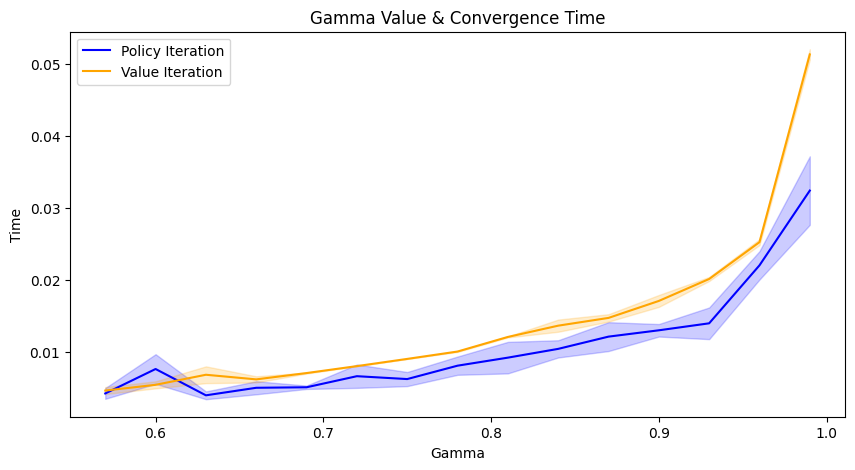

In [29]:
#Plot number Time for Value iteration
fig=plt.figure()
fig.set_size_inches(10,5)
plt.title('Gamma Value & Convergence Time')
#plt.scatter(gammas,times_policy_iterations.mean(axis=1),label='Policy Iteration',color='blue')
plt.plot(gammas,times_policy_iterations.mean(axis=1),label='Policy Iteration',color='blue')
plt.fill_between(gammas, times_policy_iterations.mean(axis=1) - times_policy_iterations.std(axis=1), times_policy_iterations.mean(axis=1) + times_policy_iterations.std(axis=1), color='blue', alpha=0.2)
#plt.scatter(gammas,times_value_iterations.mean(axis=1),label='Value Iteration',color='orange')
plt.plot(gammas,times_value_iterations.mean(axis=1),label='Value Iteration',color='orange')
plt.fill_between(gammas, times_value_iterations.mean(axis=1) - times_value_iterations.std(axis=1), times_value_iterations.mean(axis=1) + times_value_iterations.std(axis=1), color='orange', alpha=0.2)
#plt.plot(gammas,times_policy_iterations.mean(axis=1),color='blue')
#plt.plot(gammas,times_value_iterations.mean(axis=1),color='orange')
plt.legend()
plt.xlabel('Gamma')
plt.ylabel('Time')

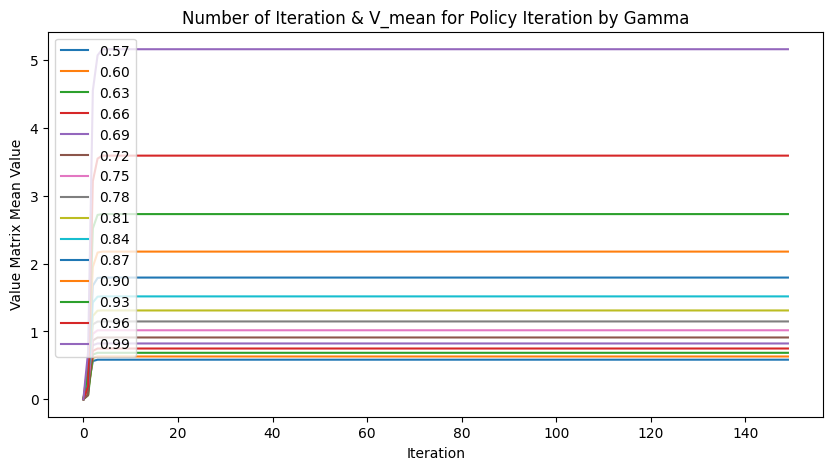

In [18]:
#Plot ting V_mean by gamma for policy iteration
cufoff=150
fig=plt.figure()
fig.set_size_inches(10,5)
plt.title('Number of Iteration & V_mean for Policy Iteration by Gamma')

for i in range(len(gammas)):
    #plt.scatter(np.arange(cufoff),vi_policy_all_iterations.mean(axis=1).mean(axis=-1)[i,:cufoff],label='{:.2f}'.format(gammas[i]))
    plt.plot(np.arange(cufoff),vi_policy_all_iterations.mean(axis=1).mean(axis=-1)[i,:cufoff],label='{:.2f}'.format(gammas[i]))
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Value Matrix Mean Value');

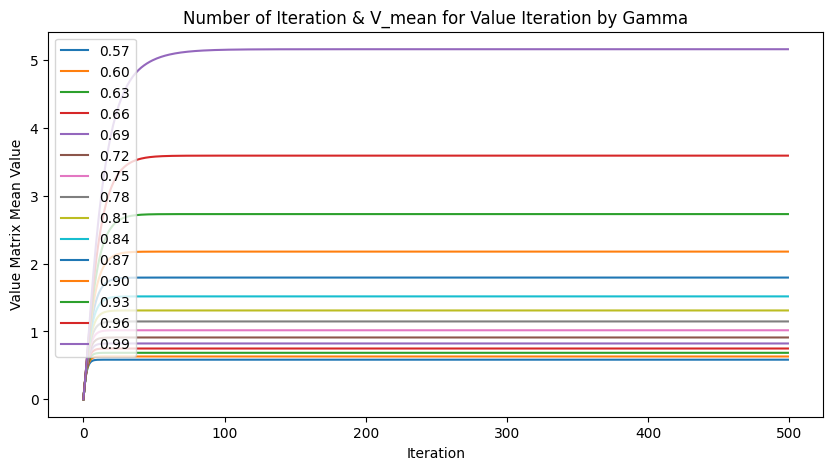

In [19]:
#Plot ting V_mean by gamma for value iteration
cufoff=500
fig=plt.figure()
fig.set_size_inches(10,5)
plt.title('Number of Iteration & V_mean for Value Iteration by Gamma')

for i in range(len(gammas)):
    #plt.scatter(np.arange(cufoff),vi_policy_all_iterations.mean(axis=1).mean(axis=-1)[i,:cufoff],label='{:.2f}'.format(gammas[i]))
    plt.plot(np.arange(cufoff),vi_value_all_iterations.mean(axis=1).mean(axis=-1)[i,:cufoff],label='{:.2f}'.format(gammas[i]))
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Value Matrix Mean Value');

In [20]:
#Sucess Rate for each ideal policy for each gamma policy iteration
attempts=20
win_rate_policy=np.zeros(shape=(gammas.shape[0],REPEATS))
reward_rate_policy=np.zeros(shape=(gammas.shape[0],REPEATS))
num_steps_won_policy=np.zeros(shape=(gammas.shape[0],REPEATS))
parent_dict=pi_policy_iteraetions

for ig,gamma in tqdm(enumerate(gammas)):
    for ir,repeat in enumerate(range(REPEATS)):
        key='{:.2f}_{}'.format(gamma,repeat)
        chosen_dict=parent_dict[key]
        won_counter=0
        reward=0
        steps=0
        for i in range(attempts):
            #Resetting the lake
            frozen_lake.reset()
            checker=0
            ended=False
            inner_steps=0
            while not ended:
                if checker==0:
                    checker+=1
                    state,r,ended,won,_=frozen_lake.step(chosen_dict[0])
                else:
                    state,r,ended,won,_=frozen_lake.step(chosen_dict[state])
                reward+=r
                inner_steps+=1
            if float(r>1):
                steps+=inner_steps    
            won_counter+=float(r>1)
        if won_counter==0:
            num_steps_won_policy[ig,ir]=np.inf
        else:
            num_steps_won_policy[ig,ir]=steps/won_counter
        win_rate_policy[ig,ir]=won_counter/attempts
        reward_rate_policy[ig,ir]=reward/attempts

0it [00:00, ?it/s]C:\Users\Admin\Desktop\School\CS_7641\Assignment_4\gym_parent\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
15it [00:00, 37.59it/s]


In [21]:
#Sucess Rate for each ideal policy for each gamma value iteration
attempts=20
win_rate_value=np.zeros(shape=(gammas.shape[0],REPEATS))
reward_rate_value=np.zeros(shape=(gammas.shape[0],REPEATS))
parenta_dict=pi_value_iteraetions
num_steps_won_value=np.zeros(shape=(gammas.shape[0],REPEATS))

for ig,gamma in tqdm(enumerate(gammas)):
    for ir,repeat in enumerate(range(REPEATS)):
        key='{:.2f}_{}'.format(gamma,repeat)
        chosen_dict=parent_dict[key]
        won_counter=0
        reward=0
        steps=0
        for i in range(attempts):
            #Resetting the lake
            frozen_lake.reset()
            checker=0
            ended=False
            inner_steps=0
            while not ended:
                if checker==0:
                    checker+=1
                    state,r,ended,won,_=frozen_lake.step(chosen_dict[0])
                else:
                    state,r,ended,won,_=frozen_lake.step(chosen_dict[state])
                reward+=r
                inner_steps+=1
            if float(r>1):
                steps+=inner_steps    
            won_counter+=float(r>1)
        if won_counter==0:
            num_steps_won_value[ig,ir]=np.inf
        else:
            num_steps_won_value[ig,ir]=steps/won_counter
        win_rate_value[ig,ir]=won_counter/attempts
        reward_rate_value[ig,ir]=reward/attempts

15it [00:00, 35.86it/s]


Text(0, 0.5, 'Average Number of Steps for Win')

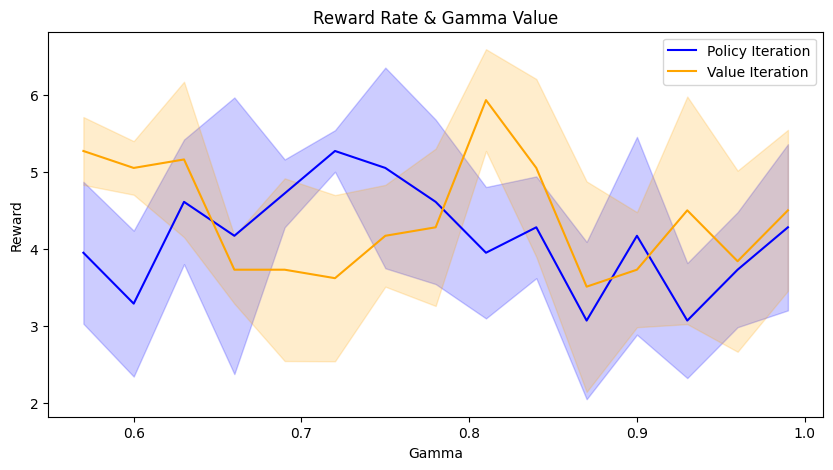

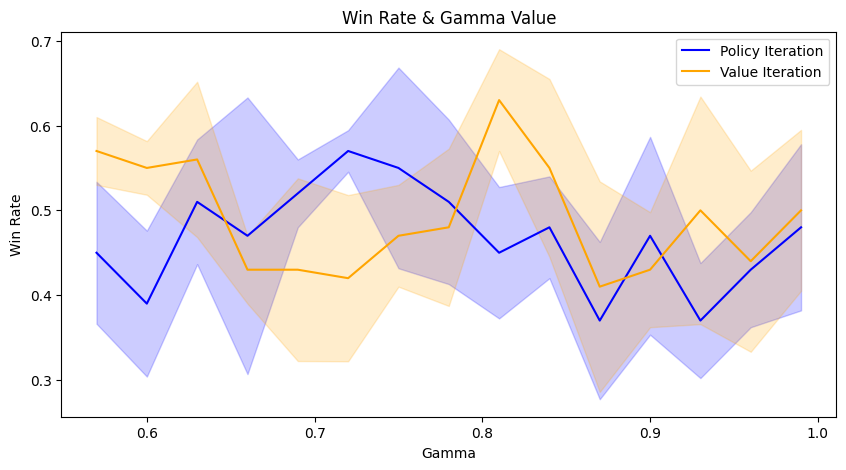

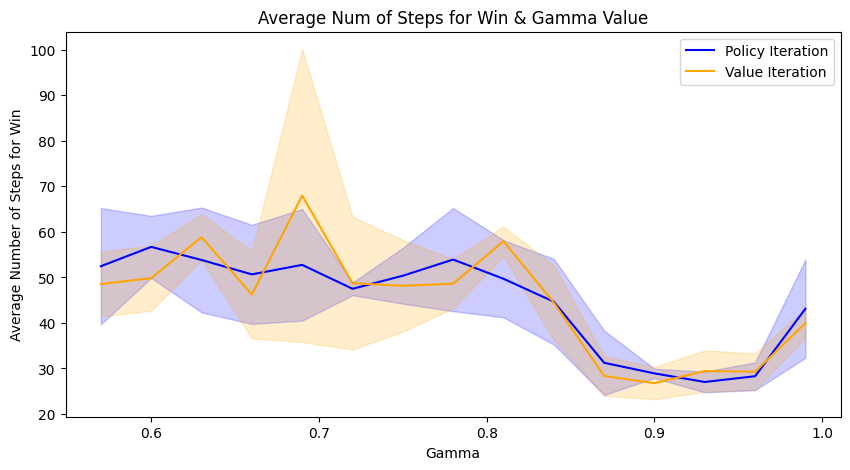

In [30]:
#Plotting win rate, average score and number of steps
fig=plt.figure()
fig.set_size_inches(10,5)
plt.title('Reward Rate & Gamma Value')
#plt.scatter(gammas,reward_rate_policy.mean(axis=1),label='Policy Iteration')
#plt.scatter(gammas,reward_rate_value.mean(axis=1),label='Value Iteration')
plt.plot(gammas,reward_rate_policy.mean(axis=1),label='Policy Iteration',color='blue')
plt.fill_between(gammas, reward_rate_policy.mean(axis=1) - reward_rate_policy.std(axis=1), reward_rate_policy.mean(axis=1) + reward_rate_policy.std(axis=1), color='blue', alpha=0.2)
plt.plot(gammas,reward_rate_value.mean(axis=1),label='Value Iteration',color='orange')
plt.fill_between(gammas, reward_rate_value.mean(axis=1) - reward_rate_value.std(axis=1), reward_rate_value.mean(axis=1) + reward_rate_value.std(axis=1), color='orange', alpha=0.2)
plt.legend()
plt.xlabel('Gamma')
plt.ylabel('Reward')

fig=plt.figure()
fig.set_size_inches(10,5)
plt.title('Win Rate & Gamma Value')
#plt.scatter(gammas,win_rate_policy.mean(axis=1),label='Policy Iteration')
#plt.scatter(gammas,win_rate_value.mean(axis=1),label='Value Iteration')
plt.plot(gammas,win_rate_policy.mean(axis=1),label='Policy Iteration',color='blue')
plt.fill_between(gammas, win_rate_policy.mean(axis=1) - win_rate_policy.std(axis=1), win_rate_policy.mean(axis=1) + win_rate_policy.std(axis=1), color='blue', alpha=0.2)
plt.plot(gammas,win_rate_value.mean(axis=1),label='Value Iteration',color='orange')
plt.fill_between(gammas, win_rate_value.mean(axis=1) - win_rate_value.std(axis=1), win_rate_value.mean(axis=1) + win_rate_value.std(axis=1), color='orange', alpha=0.2)
plt.legend()
plt.xlabel('Gamma')
plt.ylabel('Win Rate')

fig=plt.figure()
fig.set_size_inches(10,5)
plt.title('Average Num of Steps for Win & Gamma Value')
# plt.scatter(gammas,num_steps_won_policy.mean(axis=1),label='Policy Iteration')
# plt.scatter(gammas,num_steps_won_value.mean(axis=1),label='Value Iteration')
plt.plot(gammas,num_steps_won_policy.mean(axis=1),label='Policy Iteration',color='blue')
plt.fill_between(gammas, num_steps_won_policy.mean(axis=1) - num_steps_won_policy.std(axis=1), num_steps_won_policy.mean(axis=1) + num_steps_won_policy.std(axis=1), color='blue', alpha=0.2)
plt.plot(gammas,num_steps_won_value.mean(axis=1),label='Value Iteration',color='orange')
plt.fill_between(gammas, num_steps_won_value.mean(axis=1) - num_steps_won_value.std(axis=1), num_steps_won_value.mean(axis=1) + num_steps_won_value.std(axis=1), color='orange', alpha=0.2)
plt.legend()
plt.xlabel('Gamma')
plt.ylabel('Average Number of Steps for Win')

In [23]:
def viz_policy(policy,env):
    # Visualize policy
    pygame.init()
    screen = pygame.display.set_mode((512, 512))
    clock = pygame.time.Clock()
    env.reset()
    # Main loop
    running = True
    i=0
    while running:
        # Handle events
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False

        # Perform a random action
        if i==0:
            state,_,ended,won,_=env.step(policy[0])
            i+=1
        else:
            state,_,ended,won,_=env.step(policy[state])

        # Render the environment
        if hasattr(env, 'render'):
            # Use the Gym's built-in rendering method
            env.render()
            img = env.render()
            img = np.transpose(img, (1, 0, 2))  # Transpose to match Pygame's display format
            pygame.surfarray.blit_array(screen, img)
            pygame.display.flip()
        
        if ended:
            time.sleep(0.5)
            running = False

        clock.tick(60)

    # Clean up
    pygame.quit()

In [24]:
#Comparing magnitude of differences between value iteration and policy iteration
print(f'The normalized difference between both policies for all gammas and all runs is {np.linalg.norm(v_policy_iterations-v_value_iterations)} indicating convergence point was the same/similar')

The normalized difference between both policies for all gammas and all runs is 3.6999033551884125e-09 indicating convergence point was the same/similar


C:\Users\Admin\AppData\Local\Temp\ipykernel_109156\2373779083.py:20: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_policies[i]=stats.mode(big_array,axis=1)[0].ravel()


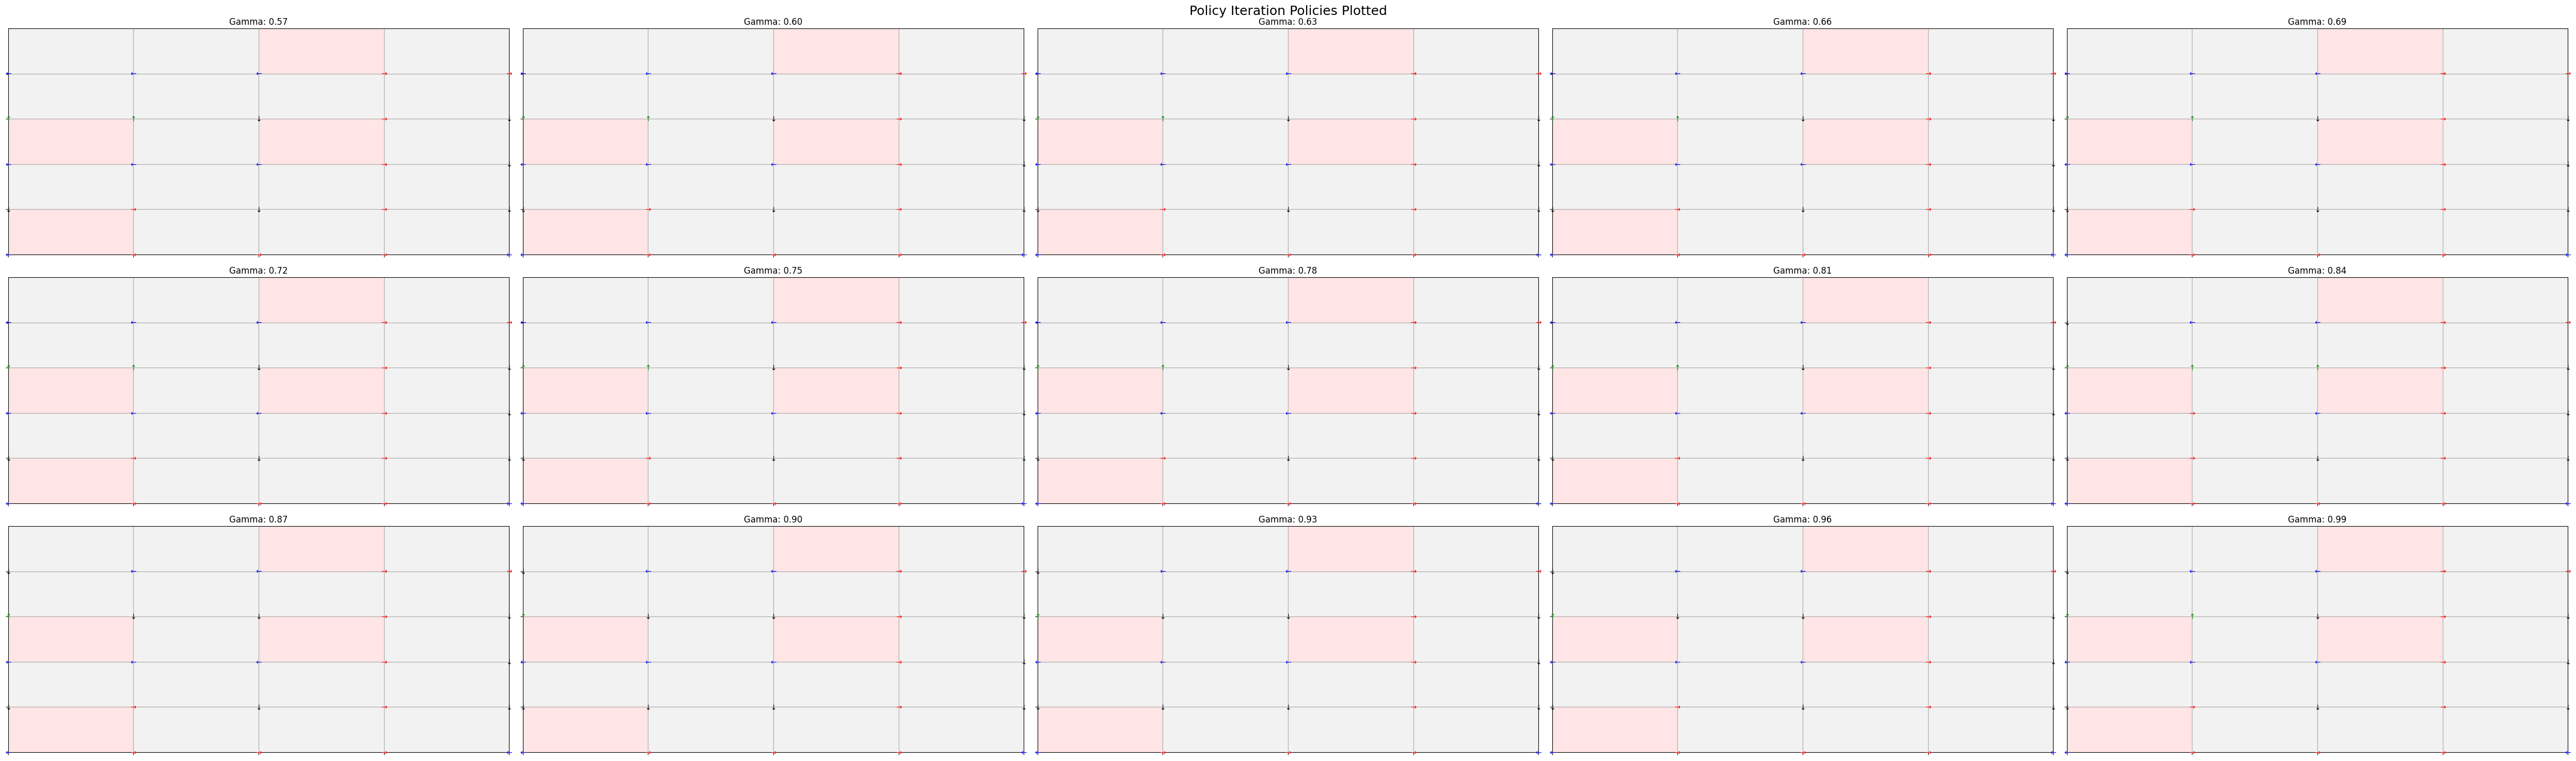

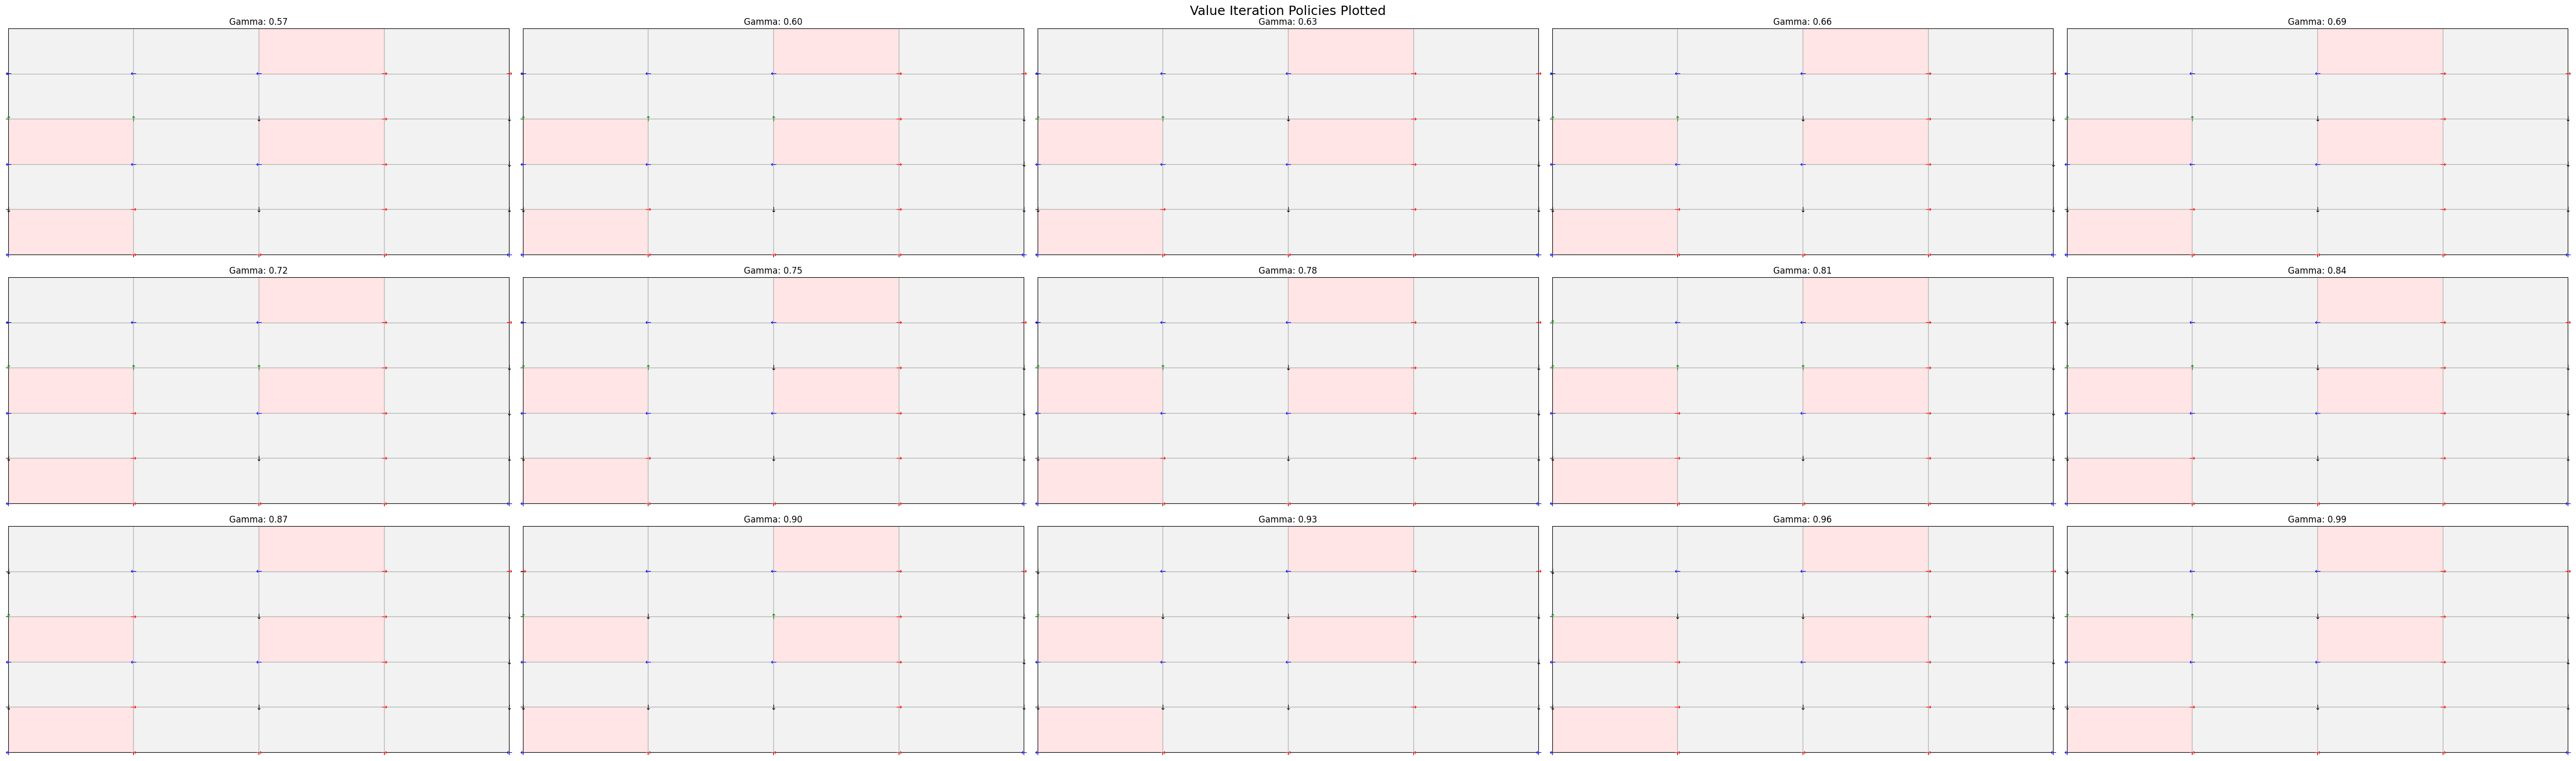

In [25]:
#Visualizing policies for different gamms for Policy and Value Iteration
mod_policy_pi=mode_policy_dict(pi_policy_iteraetions,gammas)
mod_policy_val=mode_policy_dict(pi_value_iteraetions,gammas)

#Plotting
visualize_policy(mod_policy_pi,frozen_lake.desc,gammas,title_header='Policy Iteration')
visualize_policy(mod_policy_val,frozen_lake.desc,gammas,title_header='Value Iteration')

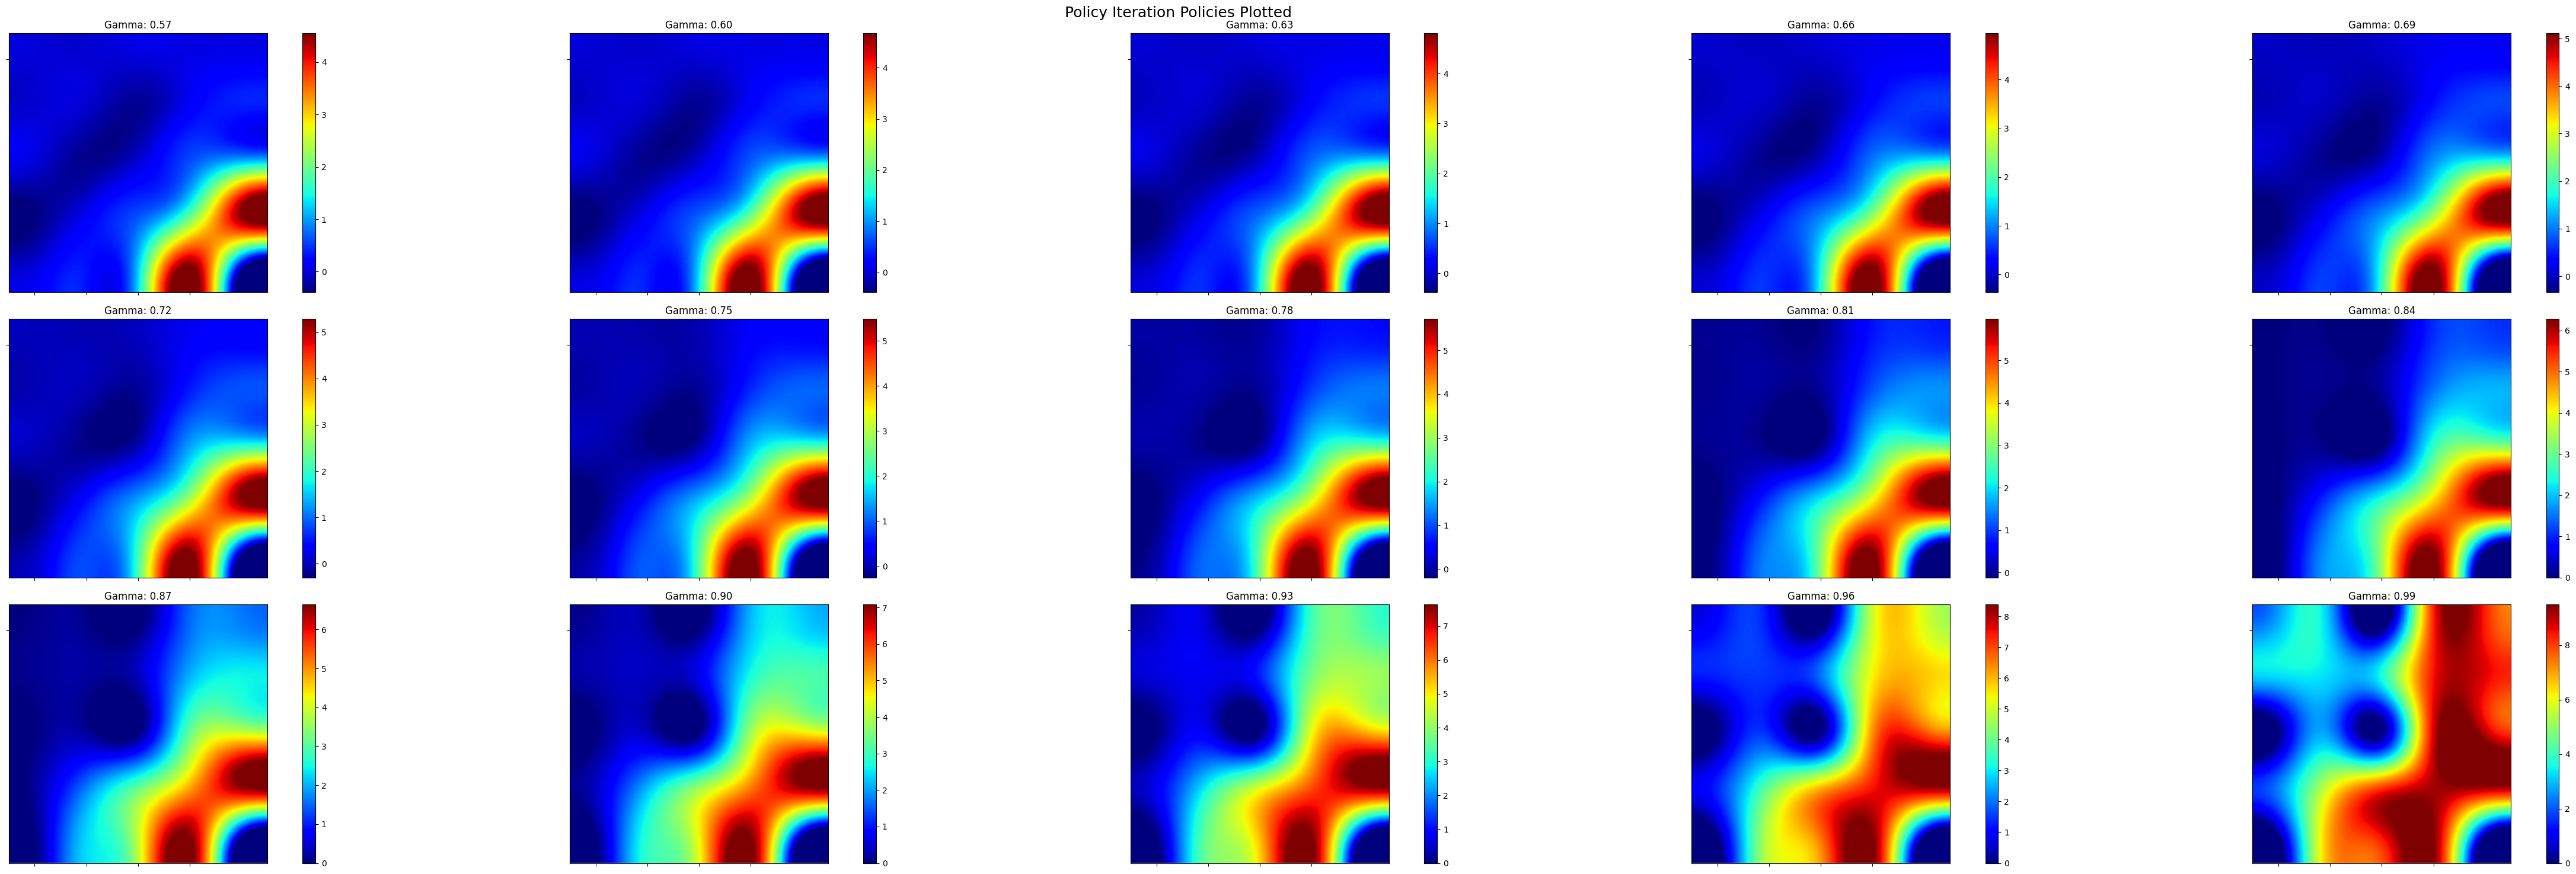

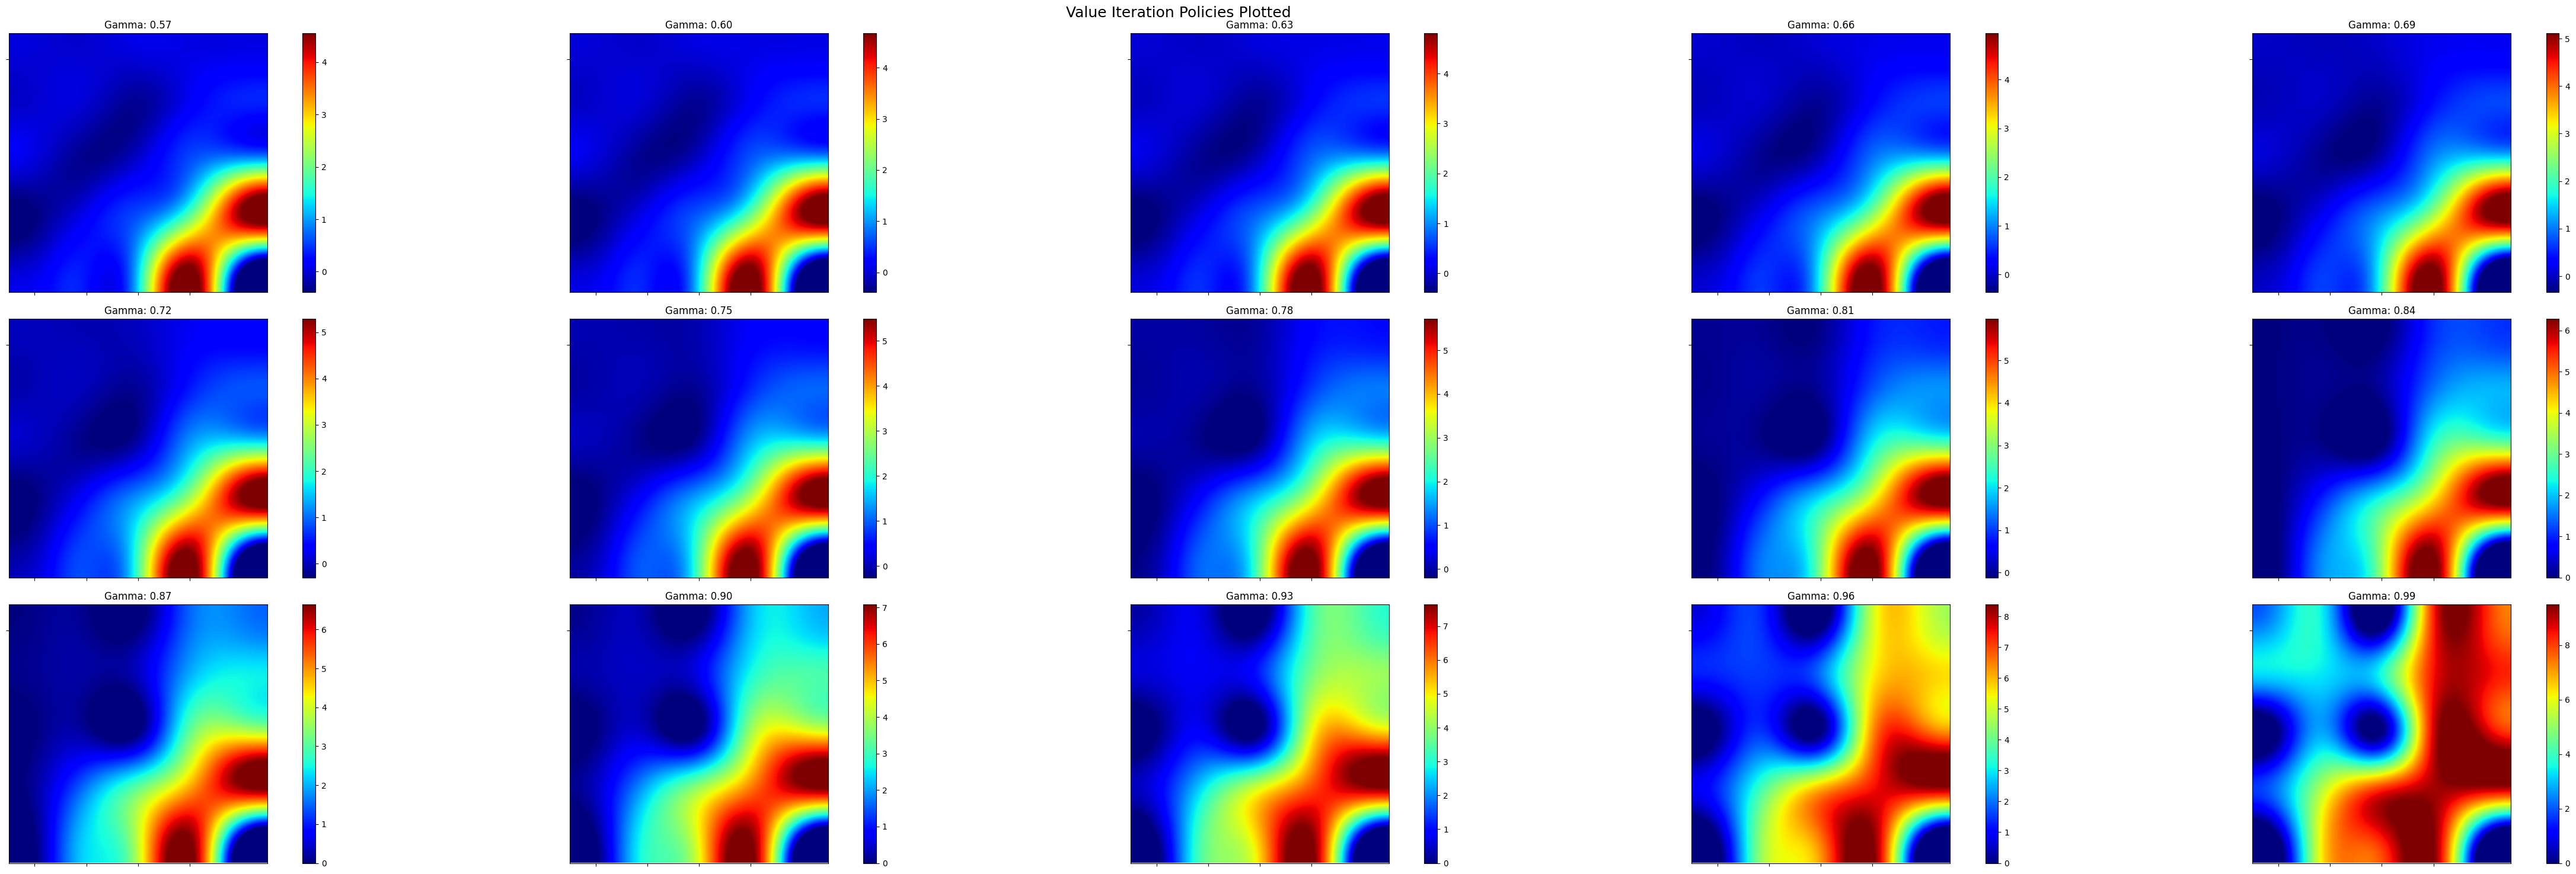

In [26]:
visualize_heatmap_states(v_policy_iterations.mean(axis=1),gammas,'Policy Iteration')
visualize_heatmap_states(v_value_iterations.mean(axis=1),gammas,'Value Iteration')

## Q Learning

In [31]:
#Applying Q Learning grid search
gammas_grid=[0.99]
gammas_grid=np.r_[gammas_grid,np.array([0.999])]

epsilon_decays=[0.99] 
iters=[int(1e5)]
#iters=[int(100000)]
env=frozen_lake
average_eval_rewards=[]
average_win_steps_results=[]
keys=[]
FILE_SAVE='saved_data/frozen_lake_gd_run_big/'

for i in itertools.product(gammas_grid, epsilon_decays, iters):

    print("running q_learning with gamma:", i[0],  "epsilon decay:", i[1],  " iterations:", i[2])
    Q, V, pi, Q_track, pi_track, total_reward, states_counter = RL(env).q_learning(gamma=i[0], epsilon_decay_ratio=i[1], n_episodes=i[2], min_alpha=0.1)

    #summed_Q=Q_track.sum(axis=1).sum(axis=-1)
    #ind_cross=np.argwhere(summed_Q==0)[0][0]
    #Q_track[ind_cross:]=Q_track[np.argwhere(summed_Q==0)[0][0]-1]
    #total_reward[ind_cross:]=total_reward[np.argwhere(total_reward==0)[0][0]-1]

    episode_rewards, average_win_steps, states_counter_app = TestEnv.test_env(env=env, n_iters=100, pi=pi)

    #Plotting rewards and Q learning visualizations + Value heat map per run
    row=1
    cols=6
    fig, axes = plt.subplots(row,cols)
    fig.set_size_inches(10*cols,5*row)
    name='Gamma  {:.2f}, Episolon_Decay_Ratio {:.2f}'.format(i[0],i[1])
    plt.suptitle(name)
    
    mode_Q=np.max(Q_track,axis=-1)
    plot_Q=mode_Q.mean(axis=-1)
    axes[0].set_title('Mean V & Episodes')
    axes[0].plot(np.arange(plot_Q.shape[0]),plot_Q)
    axes[0].set_xlabel('Episodes')
    axes[0].set_ylabel('Mean V')


    cumulative_sum = np.cumsum(total_reward)
    windowed_sum = cumulative_sum[10 - 1:] - np.concatenate([[0], cumulative_sum[:-10]])
    windowed_sum=np.r_[-10*np.ones(cumulative_sum.shape[0]-windowed_sum.shape[0]),windowed_sum]
    axes[1].set_title('Reward & Episodes (10 Episodes Averaged)')
    axes[1].plot(np.arange(windowed_sum.shape[0]),windowed_sum)
    axes[1].set_xlabel('Episodes')
    axes[1].set_ylabel('Reward & Episodes')

    axes[2].set_title('Value Heatmap')
    axes[2].set_xticks(np.arange(V.shape[0]**(0.5)))
    axes[2].set_yticks(-1*np.arange(V.shape[0]**(0.5)))
    axes[2].set_xticklabels([])
    axes[2].set_yticklabels([])
    heatmap=axes[2].imshow(V.reshape(int(len(V)**(0.5)),int(len(V)**(0.5))), cmap='jet', interpolation='lanczos')
    plt.colorbar(heatmap, ax=axes[2])
    
    visualize_policy(np.array([list(pi.values())]),frozen_lake.desc,None,None,axes_in=np.array([axes[3]]))

    axes[4].set_title('Most Common Training Steps Heatmap (Log)')
    axes[4].set_xticks(np.arange(V.shape[0]**(0.5)))
    axes[4].set_yticks(-1*np.arange(V.shape[0]**(0.5)))
    axes[4].set_xticklabels([])
    axes[4].set_yticklabels([])
    states_counter_arr=np.array(list(states_counter.values()))+1
    heatmap=axes[4].imshow(np.log(states_counter_arr).reshape(int(len(V)**(0.5)),int(len(V)**(0.5))), cmap='jet', interpolation='lanczos')
    plt.colorbar(heatmap, ax=axes[4])

    axes[5].set_title('Most Common Ideal Policy Steps Heatmap (Log)')
    axes[5].set_xticks(np.arange(V.shape[0]**(0.5)))
    axes[5].set_yticks(-1*np.arange(V.shape[0]**(0.5)))
    axes[5].set_xticklabels([])
    axes[5].set_yticklabels([])
    states_counter_app_arr=np.array(list(states_counter_app.values()))+1
    heatmap=axes[5].imshow(np.log(states_counter_app_arr).reshape(int(len(V)**(0.5)),int(len(V)**(0.5))), cmap='jet', interpolation='lanczos')
    plt.colorbar(heatmap, ax=axes[5])
    
    plt.tight_layout()
    plt.savefig('saved_plots/frozen_lake_gd_small/{}.png'.format(name))
    plt.close()
    print("Avg. Number Of Winning Steps: ", average_win_steps)
    print("Avg. episode reward: ", np.mean(episode_rewards))

    #Saving policy, Q and V
    # pd.DataFrame(Q,columns=['0','1','2','3']).to_csv(FILE_SAVE+name+'_Q.csv')
    # pd.DataFrame(V.reshape(size_val,size_val)).to_csv(FILE_SAVE+name+'_V.csv')
    # pd.DataFrame(list(pi.values()),columns=['Action']).to_csv(FILE_SAVE+name+'_pi.csv')

    average_eval_rewards.append(np.mean(episode_rewards))
    average_win_steps_results.append(average_win_steps)
    keys.append(name)
    print("###################")
    print('\n')

running q_learning with gamma: 0.99 epsilon decay: 0.99  iterations: 100000


runtime = 23.34 seconds
Avg. Number Of Winning Steps:  42.80952380952381
Avg. episode reward:  3.62
###################


running q_learning with gamma: 0.999 epsilon decay: 0.99  iterations: 100000


runtime = 24.75 seconds
Avg. Number Of Winning Steps:  34.44
Avg. episode reward:  4.5
###################




In [ ]:
#Applying Q Learning grid search
gammas_grid_2=[0.999]
#gammas_grid=np.r_[gammas_grid,np.array([0.999])]

#epsilon_decays_2=[0.01,0.99]
epsilon_decays_2
iters=[int(2.5e6)]
#iters=[int(100000)]
env=frozen_lake
average_eval_rewards_bad=[]
average_win_steps_results_bad=[]
keys=[]
FILE_SAVE='saved_data/frozen_lake_gd_run/'

for i in itertools.product(gammas_grid_2, epsilon_decays_2, iters):

    print("running q_learning with gamma:", i[0],  "epsilon decay:", i[1],  " iterations:", i[2])
    Q, V, pi, Q_track, pi_track, total_reward, states_counter = RL(env).q_learning(gamma=i[0], epsilon_decay_ratio=i[1], n_episodes=i[2], min_alpha=0.1)

    #summed_Q=Q_track.sum(axis=1).sum(axis=-1)
    #ind_cross=np.argwhere(summed_Q==0)[0][0]
    #Q_track[ind_cross:]=Q_track[np.argwhere(summed_Q==0)[0][0]-1]
    #total_reward[ind_cross:]=total_reward[np.argwhere(total_reward==0)[0][0]-1]

    episode_rewards, average_win_steps, states_counter_app = TestEnv.test_env(env=env, n_iters=100, pi=pi)

    #Plotting rewards and Q learning visualizations + Value heat map per run
    row=1
    cols=6
    fig, axes = plt.subplots(row,cols)
    fig.set_size_inches(10*cols,5*row)
    name='Gamma  {:.2f}, Episolon_Decay_Ratio {:.2f}'.format(i[0],i[1])
    plt.suptitle(name)
    
    mode_Q=np.max(Q_track,axis=-1)
    plot_Q=mode_Q.mean(axis=-1)
    axes[0].set_title('Mean V & Episodes')
    axes[0].plot(np.arange(plot_Q.shape[0]),plot_Q)
    axes[0].set_xlabel('Episodes')
    axes[0].set_ylabel('Mean V')


    cumulative_sum = np.cumsum(total_reward)
    windowed_sum = cumulative_sum[10 - 1:] - np.concatenate([[0], cumulative_sum[:-10]])
    windowed_sum=np.r_[-10*np.ones(cumulative_sum.shape[0]-windowed_sum.shape[0]),windowed_sum]
    axes[1].set_title('Reward & Episodes (10 Episodes Averaged)')
    axes[1].plot(np.arange(windowed_sum.shape[0]),windowed_sum)
    axes[1].set_xlabel('Episodes')
    axes[1].set_ylabel('Reward & Episodes')

    axes[2].set_title('Value Heatmap')
    axes[2].set_xticks(np.arange(V.shape[0]**(0.5)))
    axes[2].set_yticks(-1*np.arange(V.shape[0]**(0.5)))
    axes[2].set_xticklabels([])
    axes[2].set_yticklabels([])
    heatmap=axes[2].imshow(V.reshape(int(len(V)**(0.5)),int(len(V)**(0.5))), cmap='jet', interpolation='lanczos')
    plt.colorbar(heatmap, ax=axes[2])
    
    visualize_policy(np.array([list(pi.values())]),frozen_lake.desc,None,None,axes_in=np.array([axes[3]]))

    axes[4].set_title('Most Common Training Steps Heatmap (Log)')
    axes[4].set_xticks(np.arange(V.shape[0]**(0.5)))
    axes[4].set_yticks(-1*np.arange(V.shape[0]**(0.5)))
    axes[4].set_xticklabels([])
    axes[4].set_yticklabels([])
    states_counter_arr=np.array(list(states_counter.values()))+1
    heatmap=axes[4].imshow(np.log(states_counter_arr).reshape(int(len(V)**(0.5)),int(len(V)**(0.5))), cmap='jet', interpolation='lanczos')
    plt.colorbar(heatmap, ax=axes[4])

    axes[5].set_title('Most Common Ideal Policy Steps Heatmap (Log)')
    axes[5].set_xticks(np.arange(V.shape[0]**(0.5)))
    axes[5].set_yticks(-1*np.arange(V.shape[0]**(0.5)))
    axes[5].set_xticklabels([])
    axes[5].set_yticklabels([])
    states_counter_app_arr=np.array(list(states_counter_app.values()))+1
    heatmap=axes[5].imshow(np.log(states_counter_app_arr).reshape(int(len(V)**(0.5)),int(len(V)**(0.5))), cmap='jet', interpolation='lanczos')
    plt.colorbar(heatmap, ax=axes[5])
    
    plt.tight_layout()
    plt.savefig('saved_plots/frozen_lake_gd/{}.png'.format(name))
    plt.close()
    print("Avg. Number Of Winning Steps: ", average_win_steps)
    print("Avg. episode reward: ", np.mean(episode_rewards))

    #Saving policy, Q and V
    pd.DataFrame(Q,columns=['0','1','2','3']).to_csv(FILE_SAVE+name+'_Q.csv')
    pd.DataFrame(V.reshape(size_val,size_val)).to_csv(FILE_SAVE+name+'_V.csv')
    pd.DataFrame(list(pi.values()),columns=['Action']).to_csv(FILE_SAVE+name+'_pi.csv')

    average_eval_rewards_bad.append(np.mean(episode_rewards))
    average_win_steps_results_bad.append(average_win_steps)
    keys.append(name)
    print("###################")
    print('\n')

running q_learning with gamma: 0.01 epsilon decay: 0.01  iterations: 2500000


runtime = 10988.14 seconds
Avg. Number Of Winning Steps:  240549.3260869565
Avg. episode reward:  4.06
###################


running q_learning with gamma: 0.01 epsilon decay: 0.99  iterations: 2500000


runtime = 5974.03 seconds
Avg. Number Of Winning Steps:  203262.42592592593
Avg. episode reward:  4.94
###################


running q_learning with gamma: 0.99 epsilon decay: 0.01  iterations: 2500000


runtime = 3438.86 seconds
Avg. Number Of Winning Steps:  238.81690140845072
Avg. episode reward:  6.81
###################


running q_learning with gamma: 0.99 epsilon decay: 0.99  iterations: 2500000


runtime = 3040.01 seconds
Avg. Number Of Winning Steps:  209.0
Avg. episode reward:  6.92
###################




In [ ]:
#Applying Q Learning grid search
gammas_grid_3=[0.999]
epsilon_decays_2=[0.99]

init_epsilon=0.01
iters=[int(2.5e6)]

env=frozen_lake
average_eval_rewards_bad=[]
average_win_steps_results_bad=[]
keys=[]
FILE_SAVE='saved_data/frozen_lake_gd_run/'
name='0.999_g_0.1_init_epsilon'

for i in itertools.product(gammas_grid_3, epsilon_decays_2, iters):

    print("running q_learning with gamma:", i[0],  "epsilon decay:", i[1],  " iterations:", i[2])
    Q, V, pi, Q_track, pi_track, total_reward, states_counter = RL(env).q_learning(gamma=i[0], epsilon_decay_ratio=i[1], n_episodes=i[2], min_alpha=0.1,init_epsilon=init_epsilon)

    #summed_Q=Q_track.sum(axis=1).sum(axis=-1)
    #ind_cross=np.argwhere(summed_Q==0)[0][0]
    #Q_track[ind_cross:]=Q_track[np.argwhere(summed_Q==0)[0][0]-1]
    #total_reward[ind_cross:]=total_reward[np.argwhere(total_reward==0)[0][0]-1]

    episode_rewards, average_win_steps, states_counter_app = TestEnv.test_env(env=env, n_iters=100, pi=pi)

    #Plotting rewards and Q learning visualizations + Value heat map per run
    row=1
    cols=6
    fig, axes = plt.subplots(row,cols)
    fig.set_size_inches(10*cols,5*row)
    #name='Gamma  {:.2f}, Episolon_Decay_Ratio {:.2f}'.format(i[0],i[1])
    plt.suptitle(name)
    
    mode_Q=np.max(Q_track,axis=-1)
    plot_Q=mode_Q.mean(axis=-1)
    axes[0].set_title('Mean V & Episodes')
    axes[0].plot(np.arange(plot_Q.shape[0]),plot_Q)
    axes[0].set_xlabel('Episodes')
    axes[0].set_ylabel('Mean V')


    cumulative_sum = np.cumsum(total_reward)
    windowed_sum = cumulative_sum[10 - 1:] - np.concatenate([[0], cumulative_sum[:-10]])
    windowed_sum=np.r_[-10*np.ones(cumulative_sum.shape[0]-windowed_sum.shape[0]),windowed_sum]
    axes[1].set_title('Reward & Episodes (10 Episodes Averaged)')
    axes[1].plot(np.arange(windowed_sum.shape[0]),windowed_sum)
    axes[1].set_xlabel('Episodes')
    axes[1].set_ylabel('Reward & Episodes')

    axes[2].set_title('Value Heatmap')
    axes[2].set_xticks(np.arange(V.shape[0]**(0.5)))
    axes[2].set_yticks(-1*np.arange(V.shape[0]**(0.5)))
    axes[2].set_xticklabels([])
    axes[2].set_yticklabels([])
    heatmap=axes[2].imshow(V.reshape(int(len(V)**(0.5)),int(len(V)**(0.5))), cmap='jet', interpolation='lanczos')
    plt.colorbar(heatmap, ax=axes[2])
    
    visualize_policy(np.array([list(pi.values())]),frozen_lake.desc,None,None,axes_in=np.array([axes[3]]))

    axes[4].set_title('Most Common Training Steps Heatmap (Log)')
    axes[4].set_xticks(np.arange(V.shape[0]**(0.5)))
    axes[4].set_yticks(-1*np.arange(V.shape[0]**(0.5)))
    axes[4].set_xticklabels([])
    axes[4].set_yticklabels([])
    states_counter_arr=np.array(list(states_counter.values()))+1
    heatmap=axes[4].imshow(np.log(states_counter_arr).reshape(int(len(V)**(0.5)),int(len(V)**(0.5))), cmap='jet', interpolation='lanczos')
    plt.colorbar(heatmap, ax=axes[4])

    axes[5].set_title('Most Common Ideal Policy Steps Heatmap (Log)')
    axes[5].set_xticks(np.arange(V.shape[0]**(0.5)))
    axes[5].set_yticks(-1*np.arange(V.shape[0]**(0.5)))
    axes[5].set_xticklabels([])
    axes[5].set_yticklabels([])
    states_counter_app_arr=np.array(list(states_counter_app.values()))+1
    heatmap=axes[5].imshow(np.log(states_counter_app_arr).reshape(int(len(V)**(0.5)),int(len(V)**(0.5))), cmap='jet', interpolation='lanczos')
    plt.colorbar(heatmap, ax=axes[5])
    
    plt.tight_layout()
    plt.savefig('saved_plots/frozen_lake_gd/{}.png'.format(name))
    plt.close()
    print("Avg. Number Of Winning Steps: ", average_win_steps)
    print("Avg. episode reward: ", np.mean(episode_rewards))

    #Saving policy, Q and V
    pd.DataFrame(Q,columns=['0','1','2','3']).to_csv(FILE_SAVE+name+'_Q.csv')
    pd.DataFrame(V.reshape(size_val,size_val)).to_csv(FILE_SAVE+name+'_V.csv')
    pd.DataFrame(list(pi.values()),columns=['Action']).to_csv(FILE_SAVE+name+'_pi.csv')

    average_eval_rewards_bad.append(np.mean(episode_rewards))
    average_win_steps_results_bad.append(average_win_steps)
    keys.append(name)
    print("###################")
    print('\n')

running q_learning with gamma: 0.999 epsilon decay: 0.99  iterations: 2500000


runtime = 4038.25 seconds
Avg. Number Of Winning Steps:  257.64285714285717
Avg. episode reward:  8.24
###################




In [ ]:
#Applying Q Learning grid search
gammas_grid_3=[0.999]
epsilon_decays_2=[0.99]

init_epsilon=min_epsilon=0.001
iters=[int(2.5e6)]

env=frozen_lake
average_eval_rewards_bad=[]
average_win_steps_results_bad=[]
keys=[]
FILE_SAVE='saved_data/frozen_lake_gd_run/'
name='0.999_g_0.001_epsilon'

for i in itertools.product(gammas_grid_3, epsilon_decays_2, iters):

    print("running q_learning with gamma:", i[0],  "epsilon decay:", i[1],  " iterations:", i[2])
    Q, V, pi, Q_track, pi_track, total_reward, states_counter = RL(env).q_learning(gamma=i[0], epsilon_decay_ratio=i[1], n_episodes=i[2], min_alpha=0.1,init_epsilon=init_epsilon,min_epsilon=min_epsilon)

    #summed_Q=Q_track.sum(axis=1).sum(axis=-1)
    #ind_cross=np.argwhere(summed_Q==0)[0][0]
    #Q_track[ind_cross:]=Q_track[np.argwhere(summed_Q==0)[0][0]-1]
    #total_reward[ind_cross:]=total_reward[np.argwhere(total_reward==0)[0][0]-1]

    episode_rewards, average_win_steps, states_counter_app = TestEnv.test_env(env=env, n_iters=100, pi=pi)

    #Plotting rewards and Q learning visualizations + Value heat map per run
    row=1
    cols=6
    fig, axes = plt.subplots(row,cols)
    fig.set_size_inches(10*cols,5*row)
    #name='Gamma  {:.2f}, Episolon_Decay_Ratio {:.2f}'.format(i[0],i[1])
    plt.suptitle(name)
    
    mode_Q=np.max(Q_track,axis=-1)
    plot_Q=mode_Q.mean(axis=-1)
    axes[0].set_title('Mean V & Episodes')
    axes[0].plot(np.arange(plot_Q.shape[0]),plot_Q)
    axes[0].set_xlabel('Episodes')
    axes[0].set_ylabel('Mean V')


    cumulative_sum = np.cumsum(total_reward)
    windowed_sum = cumulative_sum[10 - 1:] - np.concatenate([[0], cumulative_sum[:-10]])
    windowed_sum=np.r_[-10*np.ones(cumulative_sum.shape[0]-windowed_sum.shape[0]),windowed_sum]
    axes[1].set_title('Reward & Episodes (10 Episodes Averaged)')
    axes[1].plot(np.arange(windowed_sum.shape[0]),windowed_sum)
    axes[1].set_xlabel('Episodes')
    axes[1].set_ylabel('Reward & Episodes')

    axes[2].set_title('Value Heatmap')
    axes[2].set_xticks(np.arange(V.shape[0]**(0.5)))
    axes[2].set_yticks(-1*np.arange(V.shape[0]**(0.5)))
    axes[2].set_xticklabels([])
    axes[2].set_yticklabels([])
    heatmap=axes[2].imshow(V.reshape(int(len(V)**(0.5)),int(len(V)**(0.5))), cmap='jet', interpolation='lanczos')
    plt.colorbar(heatmap, ax=axes[2])
    
    visualize_policy(np.array([list(pi.values())]),frozen_lake.desc,None,None,axes_in=np.array([axes[3]]))

    axes[4].set_title('Most Common Training Steps Heatmap (Log)')
    axes[4].set_xticks(np.arange(V.shape[0]**(0.5)))
    axes[4].set_yticks(-1*np.arange(V.shape[0]**(0.5)))
    axes[4].set_xticklabels([])
    axes[4].set_yticklabels([])
    states_counter_arr=np.array(list(states_counter.values()))+1
    heatmap=axes[4].imshow(np.log(states_counter_arr).reshape(int(len(V)**(0.5)),int(len(V)**(0.5))), cmap='jet', interpolation='lanczos')
    plt.colorbar(heatmap, ax=axes[4])

    axes[5].set_title('Most Common Ideal Policy Steps Heatmap (Log)')
    axes[5].set_xticks(np.arange(V.shape[0]**(0.5)))
    axes[5].set_yticks(-1*np.arange(V.shape[0]**(0.5)))
    axes[5].set_xticklabels([])
    axes[5].set_yticklabels([])
    states_counter_app_arr=np.array(list(states_counter_app.values()))+1
    heatmap=axes[5].imshow(np.log(states_counter_app_arr).reshape(int(len(V)**(0.5)),int(len(V)**(0.5))), cmap='jet', interpolation='lanczos')
    plt.colorbar(heatmap, ax=axes[5])
    
    plt.tight_layout()
    plt.savefig('saved_plots/frozen_lake_gd/{}.png'.format(name))
    plt.close()
    print("Avg. Number Of Winning Steps: ", average_win_steps)
    print("Avg. episode reward: ", np.mean(episode_rewards))

    #Saving policy, Q and V
    pd.DataFrame(Q,columns=['0','1','2','3']).to_csv(FILE_SAVE+name+'_Q.csv')
    pd.DataFrame(V.reshape(size_val,size_val)).to_csv(FILE_SAVE+name+'_V.csv')
    pd.DataFrame(list(pi.values()),columns=['Action']).to_csv(FILE_SAVE+name+'_pi.csv')

    average_eval_rewards_bad.append(np.mean(episode_rewards))
    average_win_steps_results_bad.append(average_win_steps)
    keys.append(name)
    print("###################")
    print('\n')

running q_learning with gamma: 0.999 epsilon decay: 0.99  iterations: 2500000


runtime = 8280.61 seconds
Avg. Number Of Winning Steps:  276.4698795180723
Avg. episode reward:  8.13
###################




In [ ]:
#Applying Q Learning grid search
gammas_grid_3=[0.81]
epsilon_decays_2=[0.99]

init_epsilon=min_epsilon=0.001
iters=[int(2.5e6)]

env=frozen_lake
average_eval_rewards_bad=[]
average_win_steps_results_bad=[]
keys=[]
FILE_SAVE='saved_data/frozen_lake_gd_run/'
name='0.81_g_0.001_epsilon'

for i in itertools.product(gammas_grid_3, epsilon_decays_2, iters):

    print("running q_learning with gamma:", i[0],  "epsilon decay:", i[1],  " iterations:", i[2])
    Q, V, pi, Q_track, pi_track, total_reward, states_counter = RL(env).q_learning(gamma=i[0], epsilon_decay_ratio=i[1], n_episodes=i[2], min_alpha=0.1,init_epsilon=init_epsilon,min_epsilon=min_epsilon)

    #summed_Q=Q_track.sum(axis=1).sum(axis=-1)
    #ind_cross=np.argwhere(summed_Q==0)[0][0]
    #Q_track[ind_cross:]=Q_track[np.argwhere(summed_Q==0)[0][0]-1]
    #total_reward[ind_cross:]=total_reward[np.argwhere(total_reward==0)[0][0]-1]

    episode_rewards, average_win_steps, states_counter_app = TestEnv.test_env(env=env, n_iters=100, pi=pi)

    #Plotting rewards and Q learning visualizations + Value heat map per run
    row=1
    cols=6
    fig, axes = plt.subplots(row,cols)
    fig.set_size_inches(10*cols,5*row)
    #name='Gamma  {:.2f}, Episolon_Decay_Ratio {:.2f}'.format(i[0],i[1])
    plt.suptitle(name)
    
    mode_Q=np.max(Q_track,axis=-1)
    plot_Q=mode_Q.mean(axis=-1)
    axes[0].set_title('Mean V & Episodes')
    axes[0].plot(np.arange(plot_Q.shape[0]),plot_Q)
    axes[0].set_xlabel('Episodes')
    axes[0].set_ylabel('Mean V')


    cumulative_sum = np.cumsum(total_reward)
    windowed_sum = cumulative_sum[10 - 1:] - np.concatenate([[0], cumulative_sum[:-10]])
    windowed_sum=np.r_[-10*np.ones(cumulative_sum.shape[0]-windowed_sum.shape[0]),windowed_sum]
    axes[1].set_title('Reward & Episodes (10 Episodes Averaged)')
    axes[1].plot(np.arange(windowed_sum.shape[0]),windowed_sum)
    axes[1].set_xlabel('Episodes')
    axes[1].set_ylabel('Reward & Episodes')

    axes[2].set_title('Value Heatmap')
    axes[2].set_xticks(np.arange(V.shape[0]**(0.5)))
    axes[2].set_yticks(-1*np.arange(V.shape[0]**(0.5)))
    axes[2].set_xticklabels([])
    axes[2].set_yticklabels([])
    heatmap=axes[2].imshow(V.reshape(int(len(V)**(0.5)),int(len(V)**(0.5))), cmap='jet', interpolation='lanczos')
    plt.colorbar(heatmap, ax=axes[2])
    
    visualize_policy(np.array([list(pi.values())]),frozen_lake.desc,None,None,axes_in=np.array([axes[3]]))

    axes[4].set_title('Most Common Training Steps Heatmap (Log)')
    axes[4].set_xticks(np.arange(V.shape[0]**(0.5)))
    axes[4].set_yticks(-1*np.arange(V.shape[0]**(0.5)))
    axes[4].set_xticklabels([])
    axes[4].set_yticklabels([])
    states_counter_arr=np.array(list(states_counter.values()))+1
    heatmap=axes[4].imshow(np.log(states_counter_arr).reshape(int(len(V)**(0.5)),int(len(V)**(0.5))), cmap='jet', interpolation='lanczos')
    plt.colorbar(heatmap, ax=axes[4])

    axes[5].set_title('Most Common Ideal Policy Steps Heatmap (Log)')
    axes[5].set_xticks(np.arange(V.shape[0]**(0.5)))
    axes[5].set_yticks(-1*np.arange(V.shape[0]**(0.5)))
    axes[5].set_xticklabels([])
    axes[5].set_yticklabels([])
    states_counter_app_arr=np.array(list(states_counter_app.values()))+1
    heatmap=axes[5].imshow(np.log(states_counter_app_arr).reshape(int(len(V)**(0.5)),int(len(V)**(0.5))), cmap='jet', interpolation='lanczos')
    plt.colorbar(heatmap, ax=axes[5])
    
    plt.tight_layout()
    plt.savefig('saved_plots/frozen_lake_gd/{}.png'.format(name))
    plt.close()
    print("Avg. Number Of Winning Steps: ", average_win_steps)
    print("Avg. episode reward: ", np.mean(episode_rewards))

    #Saving policy, Q and V
    pd.DataFrame(Q,columns=['0','1','2','3']).to_csv(FILE_SAVE+name+'_Q.csv')
    pd.DataFrame(V.reshape(size_val,size_val)).to_csv(FILE_SAVE+name+'_V.csv')
    pd.DataFrame(list(pi.values()),columns=['Action']).to_csv(FILE_SAVE+name+'_pi.csv')

    average_eval_rewards_bad.append(np.mean(episode_rewards))
    average_win_steps_results_bad.append(average_win_steps)
    keys.append(name)
    print("###################")
    print('\n')

running q_learning with gamma: 0.81 epsilon decay: 0.99  iterations: 2500000


KeyboardInterrupt: 

In [62]:
#Applying Q Learning grid search
gammas_grid_3=[0.999]
epsilon_decays_2=[0.99]

init_alpha=min_alpha=0.9
iters=[int(2.5e6)]

env=frozen_lake
average_eval_rewards_bad=[]
average_win_steps_results_bad=[]
keys=[]
FILE_SAVE='saved_data/frozen_lake_gd_run/'
name='0.999g_0.99ed_0.9alpha'

for i in itertools.product(gammas_grid_3, epsilon_decays_2, iters):

    print("running q_learning with gamma:", i[0],  "epsilon decay:", i[1],  " iterations:", i[2])
    Q, V, pi, Q_track, pi_track, total_reward, states_counter = RL(env).q_learning(gamma=i[0], epsilon_decay_ratio=i[1], n_episodes=i[2], min_alpha=min_alpha,init_alpha=init_alpha,init_epsilon=init_epsilon,min_epsilon=min_epsilon)

    #summed_Q=Q_track.sum(axis=1).sum(axis=-1)
    #ind_cross=np.argwhere(summed_Q==0)[0][0]
    #Q_track[ind_cross:]=Q_track[np.argwhere(summed_Q==0)[0][0]-1]
    #total_reward[ind_cross:]=total_reward[np.argwhere(total_reward==0)[0][0]-1]

    episode_rewards, average_win_steps, states_counter_app = TestEnv.test_env(env=env, n_iters=100, pi=pi)

    #Plotting rewards and Q learning visualizations + Value heat map per run
    row=1
    cols=6
    fig, axes = plt.subplots(row,cols)
    fig.set_size_inches(10*cols,5*row)
    #name='Gamma  {:.2f}, Episolon_Decay_Ratio {:.2f}'.format(i[0],i[1])
    plt.suptitle(name)
    
    mode_Q=np.max(Q_track,axis=-1)
    plot_Q=mode_Q.mean(axis=-1)
    axes[0].set_title('Mean V & Episodes')
    axes[0].plot(np.arange(plot_Q.shape[0]),plot_Q)
    axes[0].set_xlabel('Episodes')
    axes[0].set_ylabel('Mean V')


    cumulative_sum = np.cumsum(total_reward)
    windowed_sum = cumulative_sum[10 - 1:] - np.concatenate([[0], cumulative_sum[:-10]])
    windowed_sum=np.r_[-10*np.ones(cumulative_sum.shape[0]-windowed_sum.shape[0]),windowed_sum]
    axes[1].set_title('Reward & Episodes (10 Episodes Averaged)')
    axes[1].plot(np.arange(windowed_sum.shape[0]),windowed_sum)
    axes[1].set_xlabel('Episodes')
    axes[1].set_ylabel('Reward & Episodes')

    axes[2].set_title('Value Heatmap')
    axes[2].set_xticks(np.arange(V.shape[0]**(0.5)))
    axes[2].set_yticks(-1*np.arange(V.shape[0]**(0.5)))
    axes[2].set_xticklabels([])
    axes[2].set_yticklabels([])
    heatmap=axes[2].imshow(V.reshape(int(len(V)**(0.5)),int(len(V)**(0.5))), cmap='jet', interpolation='lanczos')
    plt.colorbar(heatmap, ax=axes[2])
    
    visualize_policy(np.array([list(pi.values())]),frozen_lake.desc,None,None,axes_in=np.array([axes[3]]))

    axes[4].set_title('Most Common Training Steps Heatmap (Log)')
    axes[4].set_xticks(np.arange(V.shape[0]**(0.5)))
    axes[4].set_yticks(-1*np.arange(V.shape[0]**(0.5)))
    axes[4].set_xticklabels([])
    axes[4].set_yticklabels([])
    states_counter_arr=np.array(list(states_counter.values()))+1
    heatmap=axes[4].imshow(np.log(states_counter_arr).reshape(int(len(V)**(0.5)),int(len(V)**(0.5))), cmap='jet', interpolation='lanczos')
    plt.colorbar(heatmap, ax=axes[4])

    axes[5].set_title('Most Common Ideal Policy Steps Heatmap (Log)')
    axes[5].set_xticks(np.arange(V.shape[0]**(0.5)))
    axes[5].set_yticks(-1*np.arange(V.shape[0]**(0.5)))
    axes[5].set_xticklabels([])
    axes[5].set_yticklabels([])
    states_counter_app_arr=np.array(list(states_counter_app.values()))+1
    heatmap=axes[5].imshow(np.log(states_counter_app_arr).reshape(int(len(V)**(0.5)),int(len(V)**(0.5))), cmap='jet', interpolation='lanczos')
    plt.colorbar(heatmap, ax=axes[5])
    
    plt.tight_layout()
    plt.savefig('saved_plots/frozen_lake_gd/{}.png'.format(name))
    plt.close()
    print("Avg. Number Of Winning Steps: ", average_win_steps)
    print("Avg. episode reward: ", np.mean(episode_rewards))

    #Saving policy, Q and V
    pd.DataFrame(Q,columns=['0','1','2','3']).to_csv(FILE_SAVE+name+'_Q.csv')
    pd.DataFrame(V.reshape(size_val,size_val)).to_csv(FILE_SAVE+name+'_V.csv')
    pd.DataFrame(list(pi.values()),columns=['Action']).to_csv(FILE_SAVE+name+'_pi.csv')

    average_eval_rewards_bad.append(np.mean(episode_rewards))
    average_win_steps_results_bad.append(average_win_steps)
    keys.append(name)
    print("###################")
    print('\n')

running q_learning with gamma: 0.999 epsilon decay: 0.99  iterations: 2500000


runtime = 20237.73 seconds
Avg. Number Of Winning Steps:  496.0188679245283
Avg. episode reward:  4.83
###################




In [61]:
#Applying Q Learning grid search
gammas_grid_3=[0.999]
epsilon_decays_2=[0.99]

init_alpha=min_alpha=0.01
iters=[int(2.5e6)]

env=frozen_lake
average_eval_rewards_bad=[]
average_win_steps_results_bad=[]
keys=[]
FILE_SAVE='saved_data/frozen_lake_gd_run/'
name='0.999g_0.99ed_0.01alpha'

for i in itertools.product(gammas_grid_3, epsilon_decays_2, iters):

    print("running q_learning with gamma:", i[0],  "epsilon decay:", i[1],  " iterations:", i[2])
    Q, V, pi, Q_track, pi_track, total_reward, states_counter = RL(env).q_learning(gamma=i[0], epsilon_decay_ratio=i[1], n_episodes=i[2], min_alpha=min_alpha,init_alpha=init_alpha,init_epsilon=init_epsilon,min_epsilon=min_epsilon)

    #summed_Q=Q_track.sum(axis=1).sum(axis=-1)
    #ind_cross=np.argwhere(summed_Q==0)[0][0]
    #Q_track[ind_cross:]=Q_track[np.argwhere(summed_Q==0)[0][0]-1]
    #total_reward[ind_cross:]=total_reward[np.argwhere(total_reward==0)[0][0]-1]

    episode_rewards, average_win_steps, states_counter_app = TestEnv.test_env(env=env, n_iters=100, pi=pi)

    #Plotting rewards and Q learning visualizations + Value heat map per run
    row=1
    cols=6
    fig, axes = plt.subplots(row,cols)
    fig.set_size_inches(10*cols,5*row)
    #name='Gamma  {:.2f}, Episolon_Decay_Ratio {:.2f}'.format(i[0],i[1])
    plt.suptitle(name)
    
    mode_Q=np.max(Q_track,axis=-1)
    plot_Q=mode_Q.mean(axis=-1)
    axes[0].set_title('Mean V & Episodes')
    axes[0].plot(np.arange(plot_Q.shape[0]),plot_Q)
    axes[0].set_xlabel('Episodes')
    axes[0].set_ylabel('Mean V')


    cumulative_sum = np.cumsum(total_reward)
    windowed_sum = cumulative_sum[10 - 1:] - np.concatenate([[0], cumulative_sum[:-10]])
    windowed_sum=np.r_[-10*np.ones(cumulative_sum.shape[0]-windowed_sum.shape[0]),windowed_sum]
    axes[1].set_title('Reward & Episodes (10 Episodes Averaged)')
    axes[1].plot(np.arange(windowed_sum.shape[0]),windowed_sum)
    axes[1].set_xlabel('Episodes')
    axes[1].set_ylabel('Reward & Episodes')

    axes[2].set_title('Value Heatmap')
    axes[2].set_xticks(np.arange(V.shape[0]**(0.5)))
    axes[2].set_yticks(-1*np.arange(V.shape[0]**(0.5)))
    axes[2].set_xticklabels([])
    axes[2].set_yticklabels([])
    heatmap=axes[2].imshow(V.reshape(int(len(V)**(0.5)),int(len(V)**(0.5))), cmap='jet', interpolation='lanczos')
    plt.colorbar(heatmap, ax=axes[2])
    
    visualize_policy(np.array([list(pi.values())]),frozen_lake.desc,None,None,axes_in=np.array([axes[3]]))

    axes[4].set_title('Most Common Training Steps Heatmap (Log)')
    axes[4].set_xticks(np.arange(V.shape[0]**(0.5)))
    axes[4].set_yticks(-1*np.arange(V.shape[0]**(0.5)))
    axes[4].set_xticklabels([])
    axes[4].set_yticklabels([])
    states_counter_arr=np.array(list(states_counter.values()))+1
    heatmap=axes[4].imshow(np.log(states_counter_arr).reshape(int(len(V)**(0.5)),int(len(V)**(0.5))), cmap='jet', interpolation='lanczos')
    plt.colorbar(heatmap, ax=axes[4])

    axes[5].set_title('Most Common Ideal Policy Steps Heatmap (Log)')
    axes[5].set_xticks(np.arange(V.shape[0]**(0.5)))
    axes[5].set_yticks(-1*np.arange(V.shape[0]**(0.5)))
    axes[5].set_xticklabels([])
    axes[5].set_yticklabels([])
    states_counter_app_arr=np.array(list(states_counter_app.values()))+1
    heatmap=axes[5].imshow(np.log(states_counter_app_arr).reshape(int(len(V)**(0.5)),int(len(V)**(0.5))), cmap='jet', interpolation='lanczos')
    plt.colorbar(heatmap, ax=axes[5])
    
    plt.tight_layout()
    plt.savefig('saved_plots/frozen_lake_gd/{}.png'.format(name))
    plt.close()
    print("Avg. Number Of Winning Steps: ", average_win_steps)
    print("Avg. episode reward: ", np.mean(episode_rewards))

    #Saving policy, Q and V
    pd.DataFrame(Q,columns=['0','1','2','3']).to_csv(FILE_SAVE+name+'_Q.csv')
    pd.DataFrame(V.reshape(size_val,size_val)).to_csv(FILE_SAVE+name+'_V.csv')
    pd.DataFrame(list(pi.values()),columns=['Action']).to_csv(FILE_SAVE+name+'_pi.csv')

    average_eval_rewards_bad.append(np.mean(episode_rewards))
    average_win_steps_results_bad.append(average_win_steps)
    keys.append(name)
    print("###################")
    print('\n')

running q_learning with gamma: 0.999 epsilon decay: 0.99  iterations: 2500000


KeyboardInterrupt: 

In [46]:
gammas_grid=np.arange(0.72,1.00,0.09)
gammas_grid=np.r_[gammas_grid,np.array([0.999])]
epsilon_decays=np.arange(0.72,1.0,0.09) 

average_reward=np.zeros((len(gammas_grid),len(epsilon_decays)))
average_win_steps_array=np.zeros((len(gammas_grid),len(epsilon_decays)))

for i,g in enumerate(gammas_grid):
    for j,e in enumerate(epsilon_decays):
        name='Gamma  {:.2f}, Episolon_Decay_Ratio {:.2f}'.format(g,e)

        ideal_pi='saved_data/frozen_lake_gd_run/'+name+'_pi.csv'
        pi_saved=pd.read_csv(ideal_pi).drop(columns=['Unnamed: 0']).to_dict()['Action']

        episode_rewards, average_win_steps, states_counter_app = TestEnv.test_env(env=env, n_iters=100, pi=pi_saved)

        average_reward[i,j]=np.mean(episode_rewards)
        average_win_steps_array[i,j]=average_win_steps

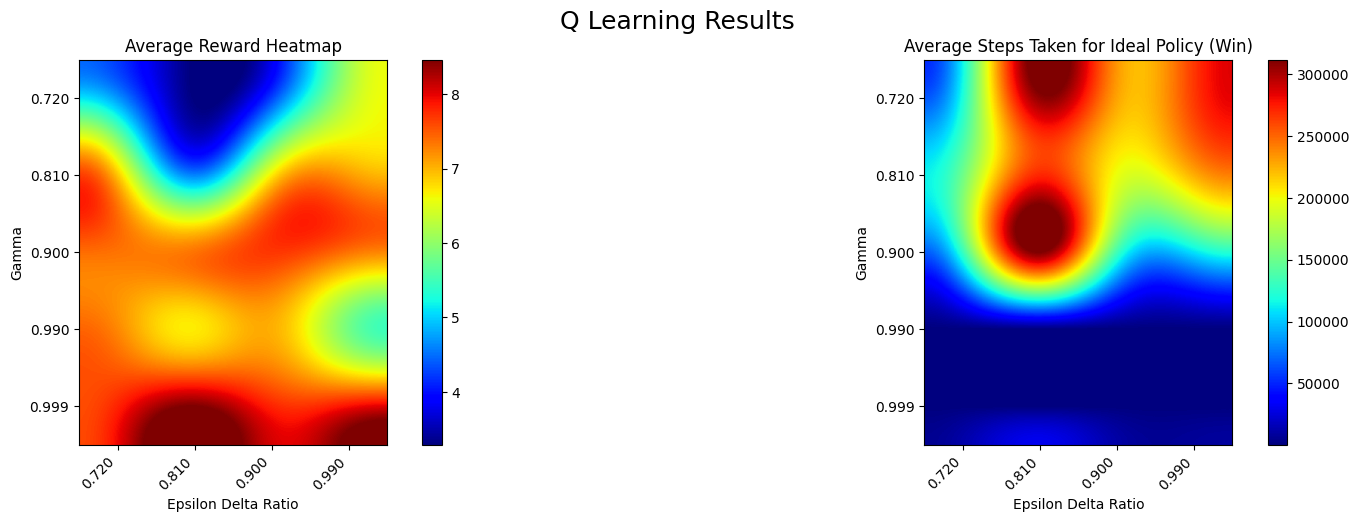

In [60]:
#Plotting Heat Map
#Plotting into heatmaps
row=1
cols=2
fig, axes = plt.subplots(row,cols)
fig.set_size_inches(10*cols,5*row)
name='Q Learning Results'
plt.suptitle('                          Q Learning Results',fontsize=18)

x_labels=['{:.3f}'.format(i) for i in epsilon_decays]
y_labels=['{:.3f}'.format(i) for i in gammas_grid]

axes[0].set_title('Average Reward Heatmap')
axes[0].set_xticks(np.arange(epsilon_decays.shape[0]))
axes[0].set_yticks(np.arange(gammas_grid.shape[0]))
axes[0].set_xticklabels(x_labels, rotation=45, ha='right')
axes[0].set_yticklabels(y_labels)
axes[0].set_xlabel('Epsilon Delta Ratio')
axes[0].set_ylabel('Gamma')
heatmap=axes[0].imshow(average_reward, cmap='jet', interpolation='lanczos')
plt.colorbar(heatmap, ax=axes[0])

axes[1].set_title('Average Steps Taken for Ideal Policy (Win)')
axes[1].set_xticks(np.arange(epsilon_decays.shape[0]))
axes[1].set_yticks(np.arange(gammas_grid.shape[0]))
axes[1].set_xticklabels(x_labels, rotation=45, ha='right')
axes[1].set_yticklabels(y_labels)
axes[1].set_xlabel('Epsilon Delta Ratio')
axes[1].set_ylabel('Gamma')
heatmap=axes[1].imshow(average_win_steps_array, cmap='jet', interpolation='lanczos')
plt.colorbar(heatmap, ax=axes[1])